<a href="https://colab.research.google.com/github/nguyen-nhat-mai/object_detection/blob/main/Rotate_img_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import cv2
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal

In [22]:
# Convert box coordinate from yolo to voc
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    voc = []
    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))
    return [int(v) for v in voc]

In [57]:
# Plot yolo box
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}
def plot_box(box_yolo_coordinates, height, width):
  ''' Input: list of boxes
      Output: plot of boxes'''
  for row in box_yolo_coordinates:
    bbox = row.strip('\n').split(' ')
    [x1,y1,x2,y2] = yoloFormattocv(Decimal(bbox[1]),Decimal(bbox[2]),Decimal(bbox[3]),Decimal(bbox[4]),height, width)
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[int(bbox[0])], facecolor='none', lw=1))
    plt.annotate(box_name[int(bbox[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(bbox[0])], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

['5 0.421042 0.590788 0.045501 0.129506\n',
 '5 0.230337 0.614152 0.113754 0.074766\n',
 '5 0.347436 0.764352 0.061561 0.084112\n',
 '2 0.344091 0.759680 0.095018 0.048064\n',
 '2 0.245058 0.600801 0.121783 0.072096\n',
 '9 0.435763 0.718959 0.235537 0.089453']

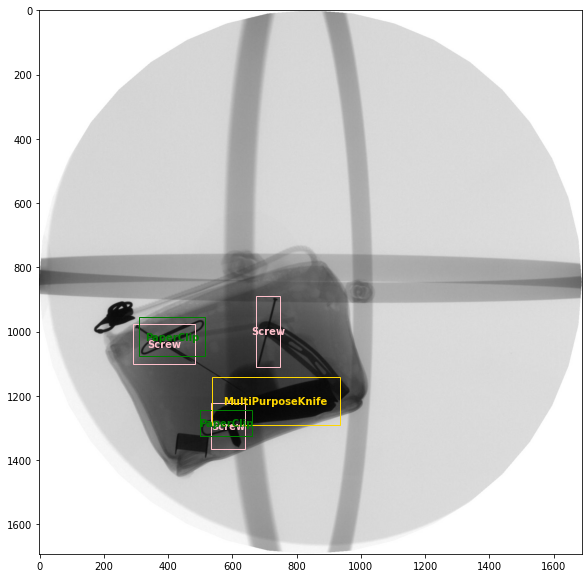

In [70]:
# Plot test image and its box
image_name = 'B0072_0001'
image_ext = '.png'
image = cv2.imread(image_name + image_ext)
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(image)

height, width,_ = image.shape
f = open(image_name + '.txt', 'r')
box_list = f.readlines()
plot_box(box_list, height, width)
box_list

In [73]:
def vocFormattoYolo(corner, H, W):
    ''' Input: list of coordinates in voc format ['label','x1','y1','x2','y2']
        Output: list of coordinates in yolo format 'label x_center y_center box_width box_height' '''
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]

    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2

    return corner[0]+' '+str(round(center_bbox_x / W, 6))+' '+str(round(center_bbox_y / H, 6))+' '+str(round(bbox_W / W, 6))+' '+str(round(bbox_H / H, 6))

In [81]:
class yoloRotatebbox:
    def __init__(self, filename, image_ext, angle):
        assert os.path.isfile(filename + image_ext)
        assert os.path.isfile(filename + '.txt')

        self.filename = filename
        self.image_ext = image_ext
        self.angle = angle

        # Read image using cv2
        self.image = cv2.imread(self.filename + self.image_ext, 1)

        # create a 2D-rotation matrix
        rotation_angle = self.angle * np.pi / 180
        self.rot_matrix = np.array(
            [[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
    def rotate_image(self):
        """
        Rotates an image (angle in degrees) and expands image to avoid cropping
        """
        height, width = self.image.shape[:2]  # image shape has 3 dimensions
        image_center = (width / 2,
                        height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origin) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(self.image, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def rotateYolobbox(self):

        new_height, new_width = self.rotate_image().shape[:2]

        f = open(self.filename + '.txt', 'r')

        f1 = f.readlines()

        yolo_bbox = []

        H, W = self.image.shape[:2]

        for x in f1:
            bbox = x.strip('\n').split(' ')
            if len(bbox) > 1:
                (center_x, center_y, bbox_width, bbox_height) = yoloFormattocv(float(bbox[1]), float(bbox[2]),
                                                                               float(bbox[3]), float(bbox[4]), H, W)
                
                # shift the origin to the center of the image.
                upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
                upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
                lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
                lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)

                new_lower_right_corner = [-1, -1]
                new_upper_left_corner = []

                for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                          lower_right_corner_shift):
                    new_coords = np.matmul(self.rot_matrix, np.array((i[0], -i[1])))
                    x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                    if new_lower_right_corner[0] < x_prime:
                        new_lower_right_corner[0] = x_prime
                    if new_lower_right_corner[1] < y_prime:
                        new_lower_right_corner[1] = y_prime

                    if len(new_upper_left_corner) > 0:
                        if new_upper_left_corner[0] > x_prime:
                            new_upper_left_corner[0] = x_prime
                        if new_upper_left_corner[1] > y_prime:
                            new_upper_left_corner[1] = y_prime
                    else:
                        new_upper_left_corner.append(x_prime)
                        new_upper_left_corner.append(y_prime)
                #             print(x_prime, y_prime)

                voc_bbox = [bbox[0], new_upper_left_corner[0], new_upper_left_corner[1],
                                 new_lower_right_corner[0], new_lower_right_corner[1]]
                yolo_bbox.append(vocFormattoYolo(voc_bbox,H,W))

        return yolo_bbox

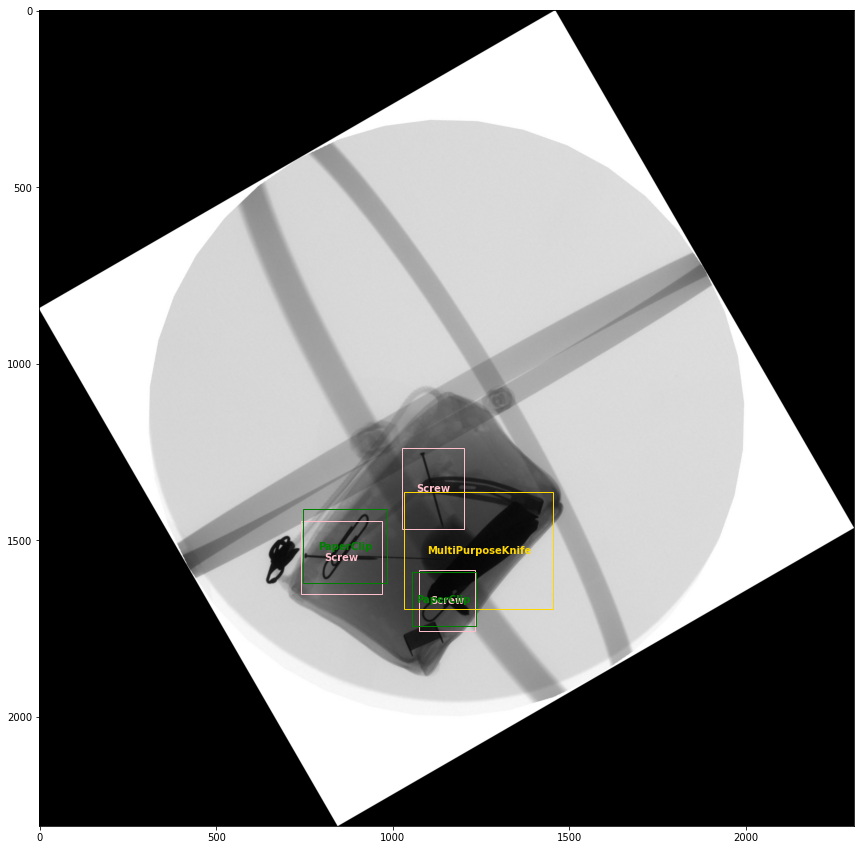

In [82]:
im = yoloRotatebbox(image_name, image_ext, 30)
image_30 = im.rotate_image()
bbox_30 = im.rotateYolobbox()

plt.rcParams["figure.figsize"] = (30,15)
plt.imshow(image_30)
plot_box(bbox_30, height, width)